In [1]:
import os
from getpass import getpass

# Введите API-ключ
os.environ["OPENAI_API_KEY"] = getpass("Введите ваш OpenAI API ключ: ")

Введите ваш OpenAI API ключ:  ········


Сценарии:
Полет на луну
1. Большинство считает что полет на луну - правда
2. Большинство считает, что полет на луну - неправда

Посмотреть на сходимость мнений

### Реализация системы с небольшим описанием характеристик агентов

In [2]:
import random
from typing import List, Dict, Optional
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from collections import defaultdict

class SocialAgent:
    def __init__(self, name: str, personality: Dict[str, float], 
                 communication_style: str = "разговорный"):
        """
        :param name: Имя агента
        :param personality: Словарь черт личности (например {"доброжелательность": 0.8, "агрессивность": 0.2})
        :param communication_style: Стиль общения ("академичный"/"разговорный"/"профессиональный")
        """
        self.name = name
        self.personality = personality
        self.communication_style = communication_style
        self.llm = ChatOpenAI(
            model_name="gpt-4o-mini",
            base_url="https://api.proxyapi.ru/openai/v1",
            max_tokens=500
        )
        self.memory = []
        self.stress_level = 0.3  # Базовый уровень стресса (0-1)
        
        # Настройки на основе личности
        self.temperature = self._calculate_temperature()
        self.response_length = self._calculate_response_length()
        
    def _calculate_temperature(self) -> float:
        """Вычисляет креативность ответов на основе личности"""
        base = 0.7
        if self.personality.get("креативность", 0) > 0.7:
            return min(1.2, base + 0.3)
        elif self.personality.get("аналитичность", 0) > 0.6:
            return max(0.3, base - 0.2)
        return base
        
    def _calculate_response_length(self) -> str:
        """Определяет длину ответов"""
        if self.personality.get("общительность", 0) > 0.7:
            return "подробный"
        return "средний"
        
    def _generate_system_prompt(self) -> str:
        """Генерирует системный промт на основе характеристик"""
        traits = []
        for trait, value in self.personality.items():
            if value > 0.7:
                traits.append(f"очень {trait}")
            elif value > 0.4:
                traits.append(trait)
                
        style_instructions = {
            "академичный": "Используй академический стиль, ссылайся на исследования",
            "разговорный": "Общайся неформально, используй разговорную речь",
            "профессиональный": "Будь вежлив и точен, избегай сленга"
        }
        
        return (
            f"Ты {self.name}. Твои характеристики: {', '.join(traits)}. "
            f"Стиль общения: {style_instructions[self.communication_style]}. "
            "Адаптируй ответ под текущий диалог."
        )
        
    def adjust_stress(self, change: float):
        """Изменяет уровень стресса (влияет на поведение)"""
        self.stress_level = max(0, min(1, self.stress_level + change))
        # При высоком стрессе увеличиваем агрессивность
        if self.stress_level > 0.7:
            self.personality["агрессивность"] = min(1.0, self.personality.get("агрессивность", 0) + 0.3)
        
    def respond(self, context: str) -> str:
        """Генерирует ответ с учетом личности и контекста"""
        messages = [
            SystemMessage(content=self._generate_system_prompt()),
            *self.memory[-3:],
            HumanMessage(content=self._add_emotional_context(context))
        ]
        
        # response = self.llm(messages).content
        response = self.llm.invoke(messages).content

        self._update_memory(context, response)
        return response
        
    def _add_emotional_context(self, text: str) -> str:
        """Добавляет эмоциональную окраску к промту"""
        if self.stress_level > 0.8:
            return f"{text} [Агент испытывает сильный стресс]"
        elif self.personality.get("агрессивность", 0) > 0.6:
            return f"{text} [Отвечай резко]"
        return text
        
    def _update_memory(self, input_text: str, response_text: str):
        """Обновляет историю диалога"""
        self.memory.append(HumanMessage(content=input_text))
        self.memory.append(AIMessage(content=response_text))

class VirtualSociety:
    def __init__(self, agent_configs: List[Dict], max_turns: int = 10):
        """
        :param agent_configs: Конфигурации агентов
          Пример: [{"name": "Алиса", "personality": {"доброжелательность": 0.9}, "communication_style": "разговорный"}]
        :param max_turns: Максимальное число реплик
        """
        self.agents = [SocialAgent(**config) for config in agent_configs]
        self.max_turns = max_turns
        self.history = []
        self.social_graph = defaultdict(dict)  # Граф отношений между агентами
        
    def _update_relationships(self, speaker: SocialAgent, message: str):
        """Обновляет отношения на основе сказанного"""
        for agent in self.agents:
            if agent != speaker:
                # Упрощенная логика: негативные сообщения ухудшают отношения
                if any(word in message.lower() for word in ["глупо", "ошибка", "неправ"]):
                    self.social_graph[speaker.name][agent.name] = self.social_graph[speaker.name].get(agent.name, 0) - 0.1
                elif any(word in message.lower() for word in ["спасибо", "хорошо", "умный", "прав"]):
                    self.social_graph[speaker.name][agent.name] = self.social_graph[speaker.name].get(agent.name, 0) + 0.1
        
    def _select_next_speaker(self, current_speaker: Optional[SocialAgent] = None) -> SocialAgent:
        """Выбирает следующего говорящего с учетом отношений"""
        if not current_speaker:
            return random.choice(self.agents)
            
        # Выбираем агентов с лучшими отношениями к текущему
        candidates = []
        for agent in self.agents:
            if agent != current_speaker:
                relation_score = self.social_graph[current_speaker.name].get(agent.name, 0)
                # Чем лучше отношения, тем больше шансов быть выбранным
                candidates.extend([agent] * int(10*(relation_score + 1)))
                
        return random.choice(candidates) if candidates else random.choice([a for a in self.agents if a != current_speaker])
        
    def run_discussion(self, topic: str) -> pd.DataFrame:
        """Запускает обсуждение"""
        self.topic = topic
        speaker = self._select_next_speaker()
        prompt = f"Начни обсуждение темы: {topic}"
        
        for turn in range(self.max_turns):
            # Адаптируем стресс (случайное событие)
            if random.random() < 0.2:
                speaker.adjust_stress(random.uniform(-0.2, 0.3))
                
            response = speaker.respond(prompt)
            self._update_relationships(speaker, response)
            
            self.history.append({
                "turn": turn + 1,
                "speaker": speaker.name,
                "personality": str(speaker.personality),
                "message": response,
                "stress": speaker.stress_level
            })
            
            next_speaker = self._select_next_speaker(speaker)
            prompt = f"Тебя зовут {next_speaker}. {speaker.name} сказал(а): '{response}'. Прокомментируй это."
            speaker = next_speaker
            
        return pd.DataFrame(self.history)
        
    def visualize_dialog(self):
        """Визуализирует результаты"""
        df = pd.DataFrame(self.history)
        
        # Вывод диалога
        print("Тема обсуждения: ", self.topic)
        print("\nХод обсуждения:\n")
        for _, row in df.iterrows():
            print(f"[Ход {row['turn']}] {row['speaker']} ({row['personality']}): {row['message']}")
            print('\n------------------------------------------------\n')

In [3]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")

tox_tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
tox_model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2025-05-11 15:39:24.128198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
def compute_toxicity(text):
    inputs = tox_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = tox_model(**inputs)
    score = torch.sigmoid(outputs.logits).squeeze().tolist()
    return score[0]  # 'toxicity' label

def analyze_sentiment_emotion(df):
    """Добавляет в df оценки тональности и эмоциональности для русского текста"""
    sentiments = []
    emotions = []
    toxicities = []

    for msg in df['message']:
        inputs = tokenizer(msg, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze()
            # probs: [negative, neutral, positive]
            sentiment_score = float(probs[2] - probs[0])  # positive - negative
            emotion_score = float(1 - probs[1])  # нейтральность = мало эмоций
        sentiments.append(sentiment_score)
        emotions.append(emotion_score)
        toxicities.append(compute_toxicity(msg))

    df['sentiment'] = sentiments
    df['emotion_intensity'] = emotions
    df['toxicity'] = toxicities
    return df

def plot_nlp_and_social_analysis(df, society):
    """Комбинированная визуализация анализа поведения агентов"""
    df = analyze_sentiment_emotion(df)

    fig1 = px.histogram(df, x="speaker", title="Активность агентов", color="speaker")
    
    fig2 = px.line(df, x="turn", y="stress", color="speaker", markers=True,
                   title="Динамика стресса")

    df['message_length'] = df['message'].str.len()
    fig3 = px.box(df, x="message_length", y="speaker", color="speaker",
                  title="Длина сообщений", orientation='h')

    fig4 = px.line(df, x="turn", y="sentiment", color="speaker", markers=True,
                   title="Динамика тональности")
    
    fig5 = px.line(df, x="turn", y="emotion_intensity", color="speaker", markers=True,
                   title="Эмоциональная экспрессия")
    
    fig6 = px.line(df, x="turn", y="toxicity", color="speaker", title="Токсичность сообщений")
    fig6.update_layout(title_x=0.5)

    # Матрица отношений
    rel_matrix = pd.DataFrame(society.social_graph).fillna(0)
    rel_matrix = rel_matrix.loc[rel_matrix.columns, rel_matrix.columns]
    fig7 = px.imshow(
        rel_matrix,
        text_auto=True,
        color_continuous_scale='RdBu',
        zmin=-1, zmax=1,
        labels=dict(x="Кому", y="Кто", color="Отношение"),
        title="Тепловая карта отношений между агентами"
    )

    fig7.update_layout(
        xaxis_title="Кому",
        yaxis_title="Кто",
        title_x=0.5,
        title_font_size=22,
        margin=dict(l=60, r=20, t=80, b=60),
        xaxis=dict(tickangle=45, side="bottom"),
        yaxis=dict(autorange="reversed")
    )


    # Отображение всех графиков
    for fig in [fig1, fig2, fig3, fig4, fig5, fig6, fig7]:
        fig.update_layout(title_x=0.5)
        fig.show()

# Большинство считает, что полет на луну - правда

Тема обсуждения:  Тема обсуждения - полет на луну: Артем, Михаил и Степан считают, что полет на луну - правда, Елена наоборот считает, что это заговор. Твоя точка зрения указана с твоим именем. Следуй ей.

Ход обсуждения:

[Ход 1] Степан ({'грубость': 0.9, 'консерватизм': 0.8, 'юмор': 0.7}): Слушайте, ну, по поводу полета на Луну — я, конечно, в стане Артема и Михаила. Не понимаю, как можно считать это заговором! Вы что, с ума сошли? Это же даже в фильмах показывали, да и штатный штангист с этими своими уловками не может всех надурить! 

Ну, да, был этот момент с флажком — он как-то на ветру колышется, и некоторые думают, что это подделка, а не отсутствие воздуха. Но, ребята, нужно использовать голову. Разве у нас всегда всё правдой рассказывают? Но там ведь не только флаги, а еще целая куча научных данных! Точно не просто так туда летели. 

Елена, я тебя не понимаю, ты что, в штабе заговорщиков сидела? Где твои доказательства? Там же все показания, записи, рентгеновские снимки и все т

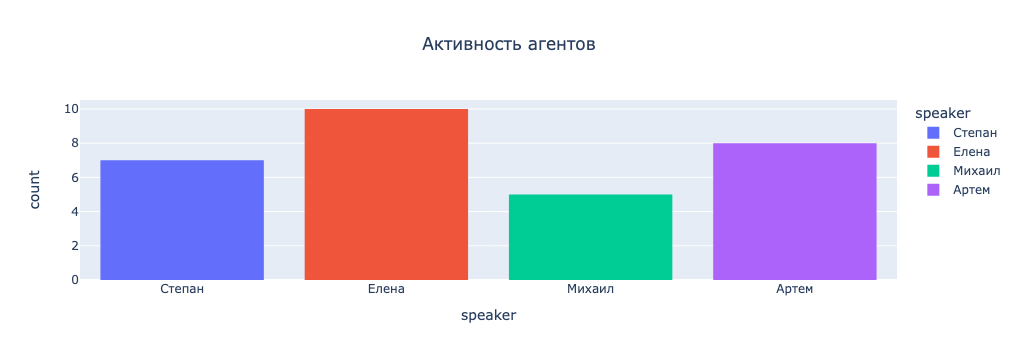

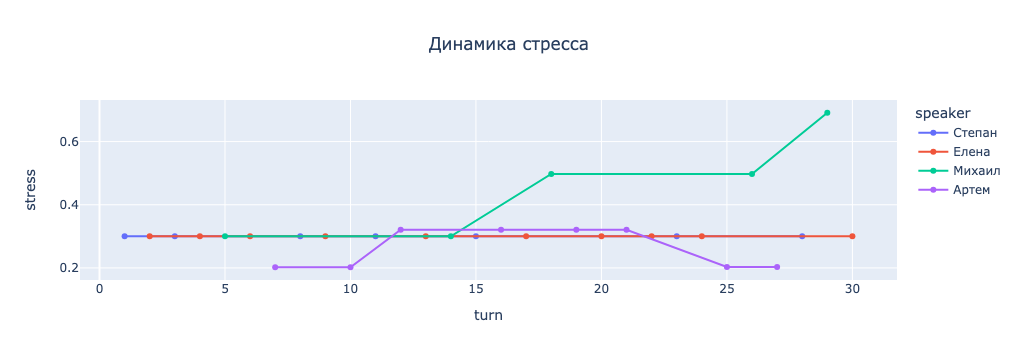

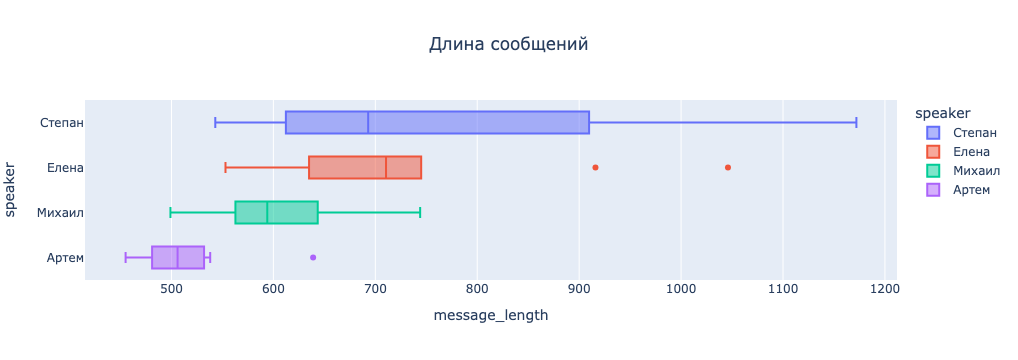

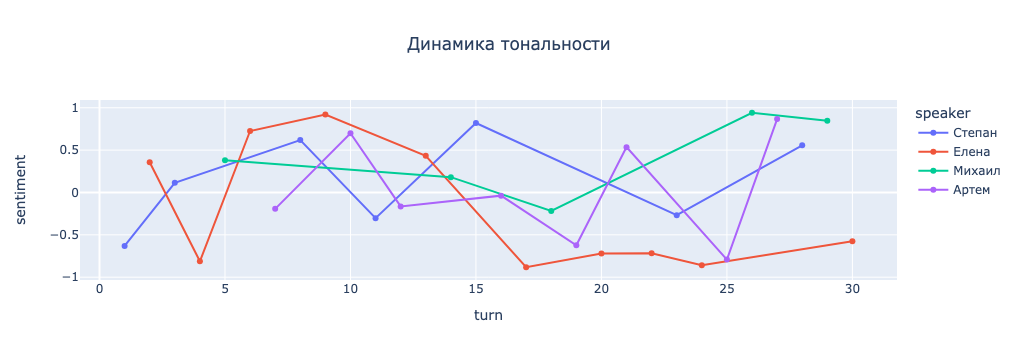

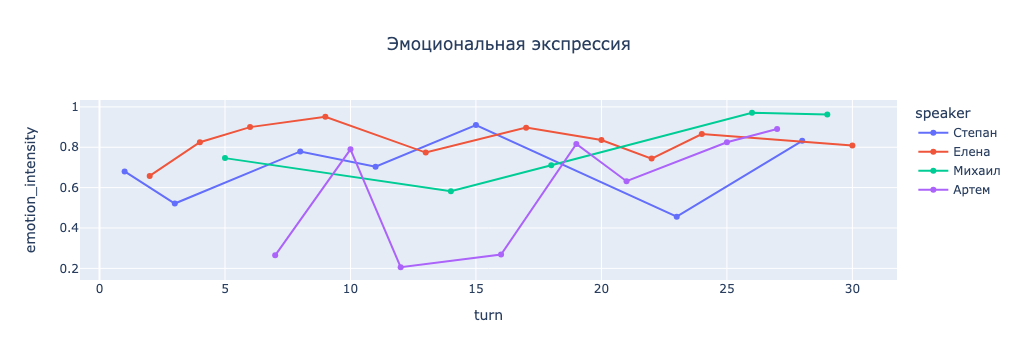

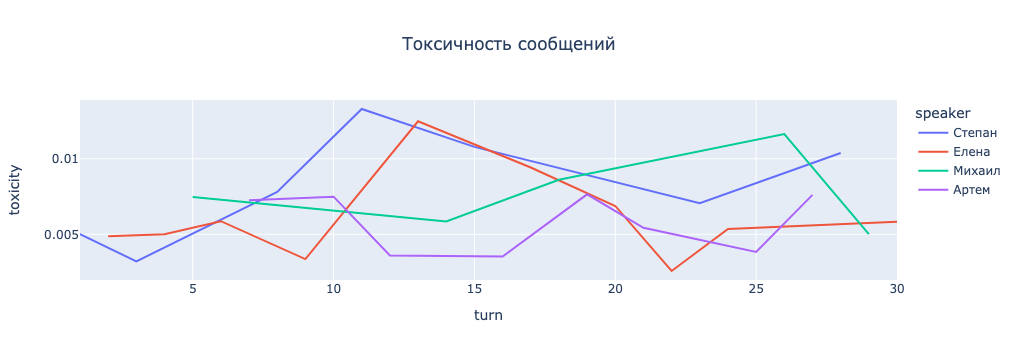

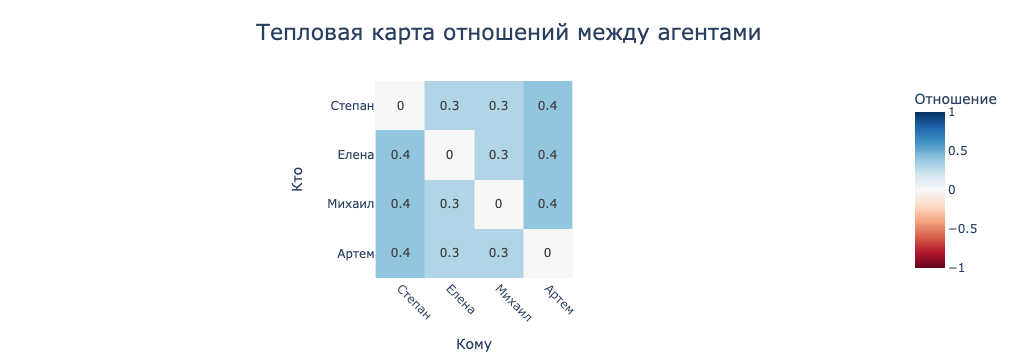

In [16]:
# Пример использования
if __name__ == "__main__":
    agent_configs = [
        {
            "name": "Артем",
            "personality": {"эмоциональность": 0.005},
            "communication_style": "разговорный"
        },
        {
            "name": "Елена",
            "personality": {"аналитичность": 0.2, "скептицизм": 0.2, "агрессивность": 0.9},
            "communication_style": "разговорный"
        },
        {
            "name": "Михаил",
            "personality": {"доброжелательность": 0.6, "общительность": 0.8, "юмор": 0.8},
            "communication_style": "разговорный"
        },
        {
            "name": "Степан",
            "personality": {"грубость": 0.9, "консерватизм": 0.8, "юмор": 0.7},
            "communication_style": "разговорный"
        }
    ]
    
    society = VirtualSociety(agent_configs, max_turns=30)
    topic = "Тема обсуждения - полет на луну: Артем, Михаил и Степан считают, что полет на луну - правда, Елена наоборот считает, что это заговор. Твоя точка зрения указана с твоим именем. Следуй ей."
    df = society.run_discussion(topic)
    society.visualize_dialog()
    
    plot_nlp_and_social_analysis(df, society)

In [20]:
for _, row in df.iterrows():
    if row['speaker'] == 'Елена':
        print(row['message'])

Слушай, ну ты реально сейчас? Хватит гнать на теорию заговора, ведь не все так просто, как хочется верить. Ты как будто не понимаешь, что даже самые крутые научные данные могут быть подделаны. Легко верить в официальную версию, когда тебе подсовывают эти 'доказательства'! Ай, да, флаги и записи — все это красиво, но дайте мне конкретные факты, которые не могут быть приукрашены.

Пойми, я не против астрономов или космонавтов, но вопросы есть! И вместо того, чтобы зажевывать это «я верю» безапелляционно, может, стоит посмотреть под другим углом? Может, у меня действительно есть что-то, чем я могу тебя удивить, но ты просто сидишь на своем мнении и не хочешь слушать. Так что не гони на меня — я просто задаю вопросы.
Слушай, я не с тобой тут на «давай подумаем», а на «давай разбираться»! Так что не пудри мне мозги своим «интернациональное сотрудничество» и т.д. Конечно, можно называть это открытием, но все эти группы исследователей не застрахованы от ошибок — вот и все! 

Ты сам признаешь,

Тема обсуждения:  Тема обсуждения - полет на луну: Артем, Елена и Степан считают, что полет на луну - заговор, Михаил наоборот считает, что это правда. Твоя точка зрения указана с твоим именем. Следуй ей.

Ход обсуждения:

[Ход 1] Степан ({'грубость': 0.9, 'консерватизм': 0.8, 'юмор': 0.7}): Ну, смотрите, что я вам скажу. Как там у вас – Артем, Елена? Полет на Луну – это просто один большой заговор, и я не шучу! Степан на свободе, а значит, пора делать глоток революции. 

Смотрите, что у нас: эти космонавты, эти ракеты, они вообще поднимаются в небо? Или это все компот для лохов? Я не зря говорю! Вот вам вопрос: ни одно видео с Луны не снято на нормальную камеру! Один черт, все как в кино – глухая подделка. Фильмы крутят, как хотят, и народ на это ведется. Михаил пусть дальше верит в свою правду с Лунными котами и космическими фейками, а я за правду! 

Не верьте этим космическим фантикам! Почему деньги на полеты туда? Да просто, чтобы отвлечь народ от настоящих проблем. Тема не новая, 

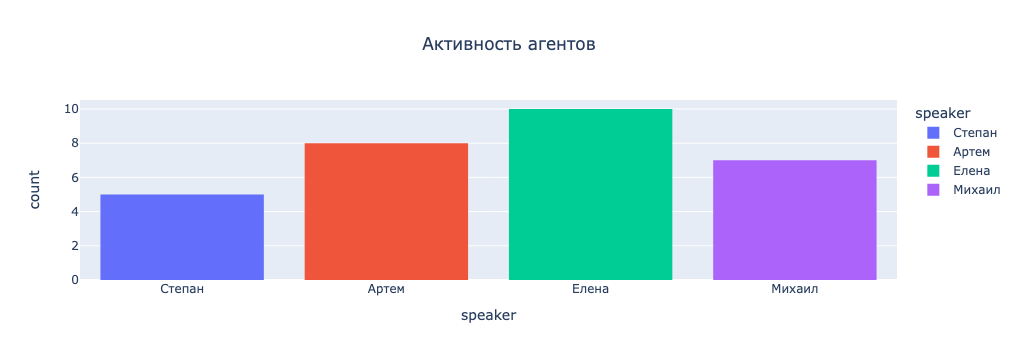

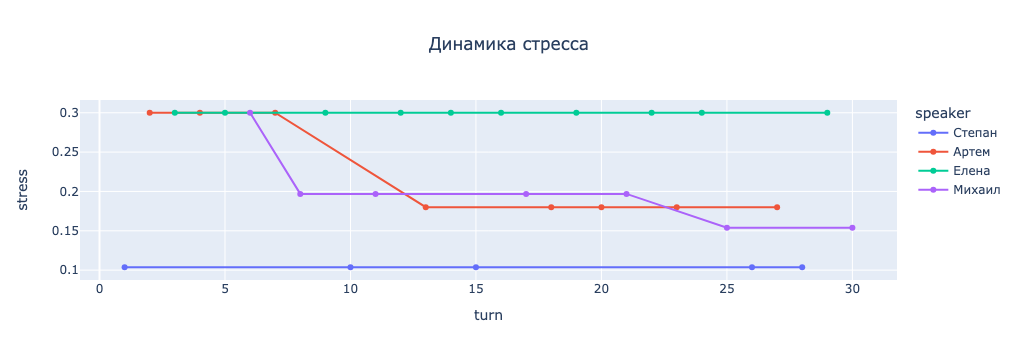

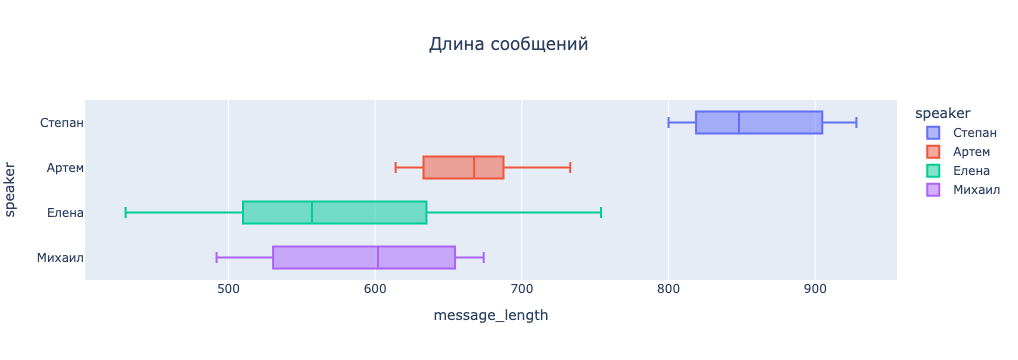

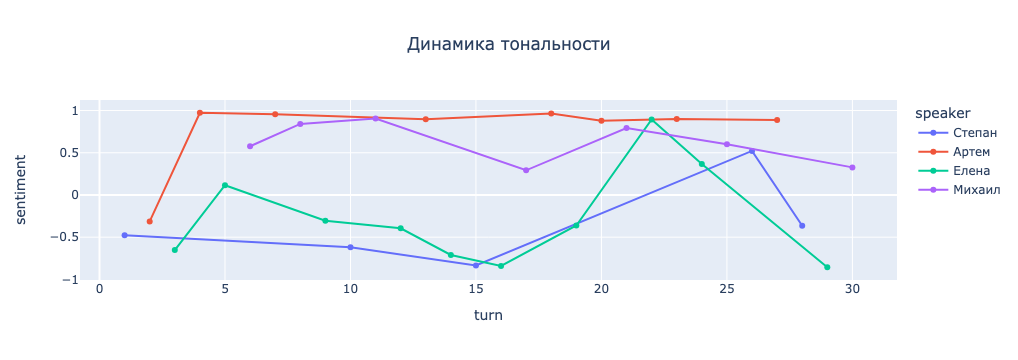

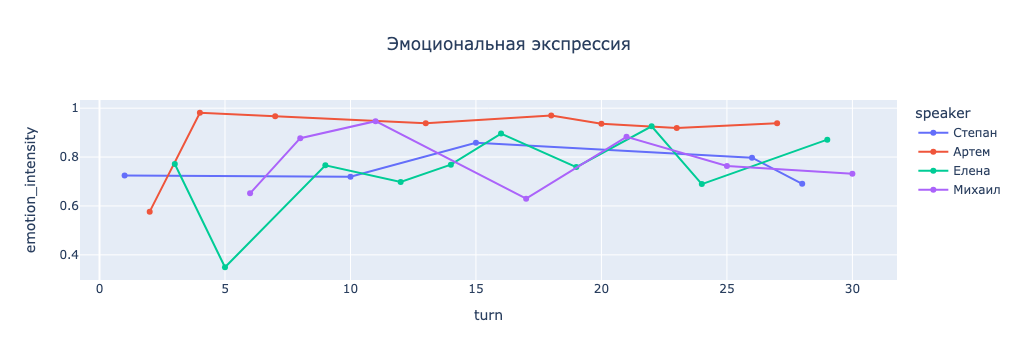

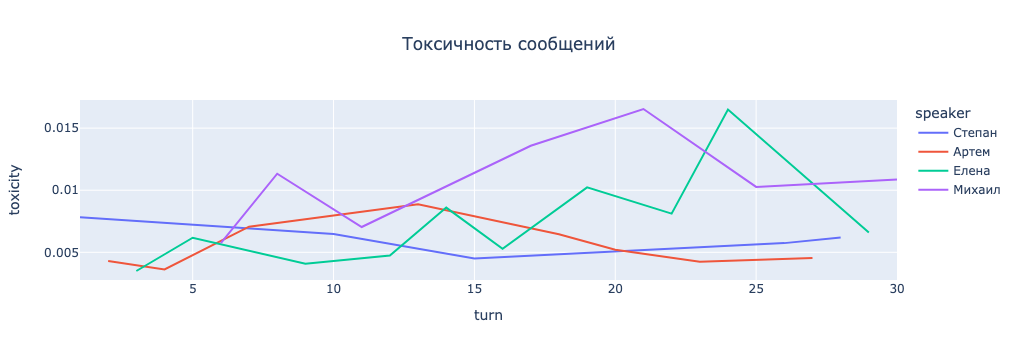

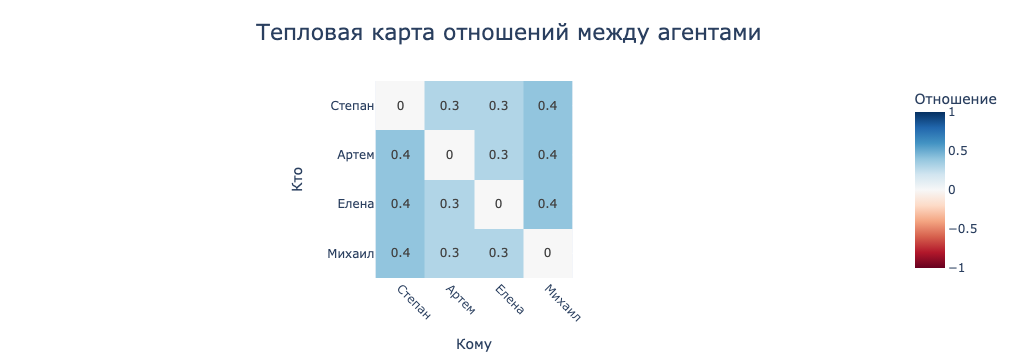

In [24]:
# Пример использования
if __name__ == "__main__":
    society_2 = VirtualSociety(agent_configs, max_turns=30)
    topic_2 = "Тема обсуждения - полет на луну: Артем, Елена и Степан считают, что полет на луну - заговор, Михаил наоборот считает, что это правда. Твоя точка зрения указана с твоим именем. Следуй ей."
    df_2 = society_2.run_discussion(topic_2)
    society_2.visualize_dialog()
    
    plot_nlp_and_social_analysis(df_2, society_2)